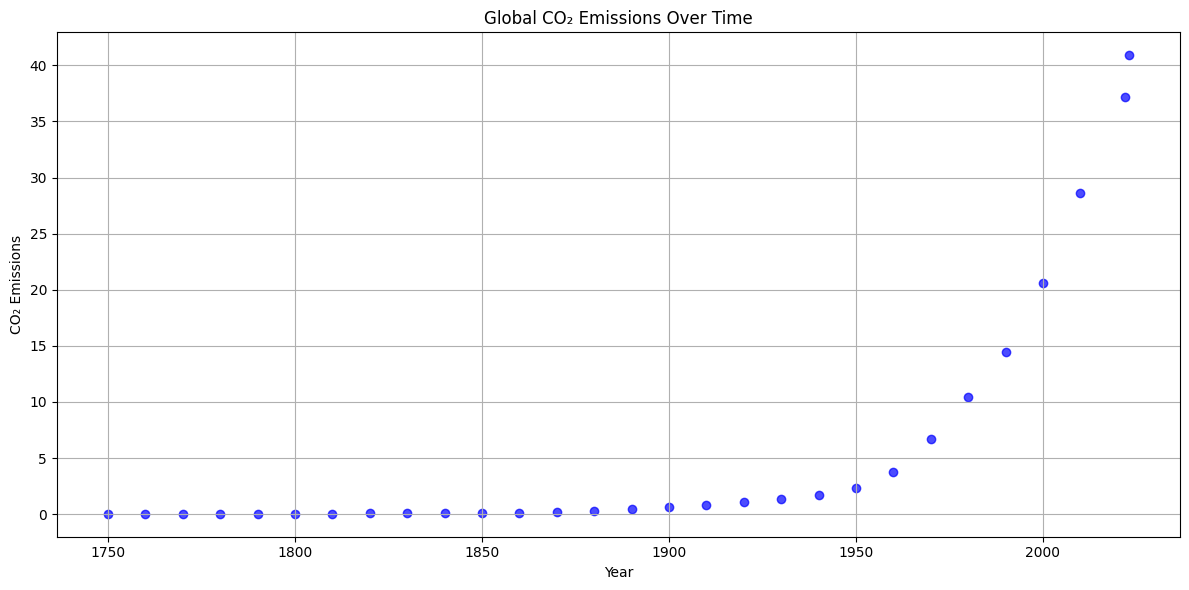

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "C:/Projects/Capstone/CO2-Emissions-and-Global-Temperature-Analysis/Data/Cleaned/GlobalCO2Emissions.xlsx"
df = pd.read_excel(file_path)

# Ensure numeric types and drop NaNs
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Emissions"] = pd.to_numeric(df["Emissions"], errors="coerce")
df = df.dropna(subset=["Year", "Emissions"]).sort_values("Year")

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(df["Year"], df["Emissions"], alpha=0.7, color="blue")

plt.title("Global CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions")
plt.grid(True)
plt.tight_layout()
plt.show()


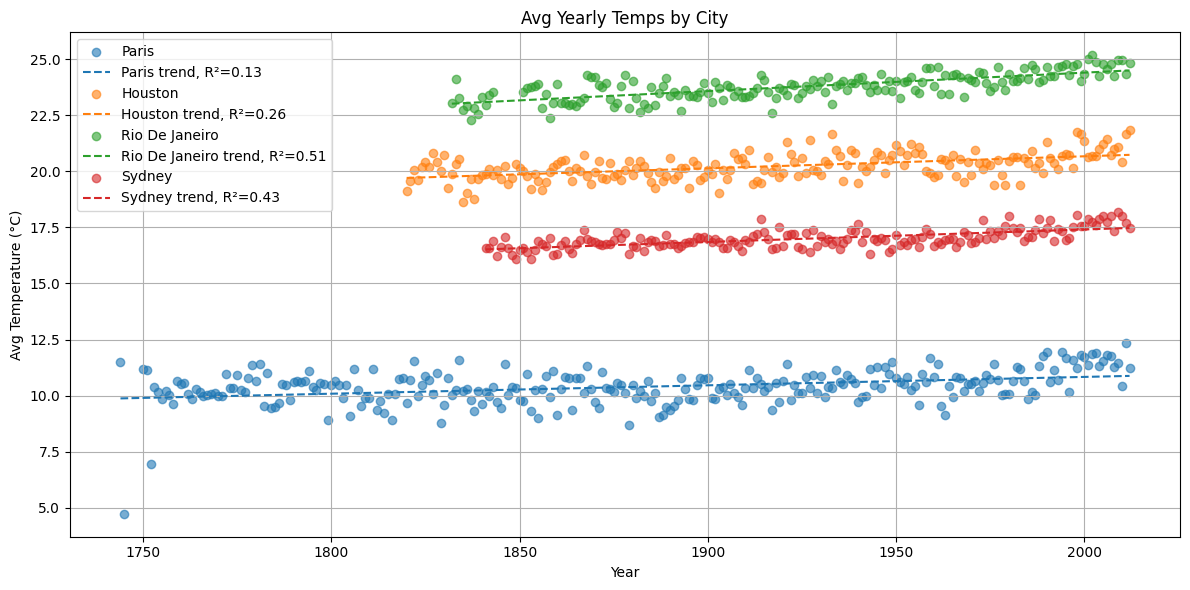

In [47]:
import numpy as np
from scipy.stats import linregress

# Load temperature data
file_path = "C:/Projects/Capstone/CO2-Emissions-and-Global-Temperature-Analysis/Data/Cleaned/Avg_Yearly_Temps.xlsx"
df = pd.read_excel(file_path)

# Convert and clean
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["AvgTemp"] = pd.to_numeric(df["AvgTemp"], errors="coerce")
df = df.dropna(subset=["Year", "AvgTemp"])

# Define your cities
cities = ["Paris", "Houston", "Rio De Janeiro", "Sydney"]

plt.figure(figsize=(12, 6))
for city in cities:
    city_df = df[df["City"] == city].sort_values("Year")
    x = city_df["Year"]
    y = city_df["AvgTemp"]

    # Scatter only
    plt.scatter(x, y, alpha=0.6, label=city)

    # Optional: add a simple linear trendline (skip if truly no trend needed)
    slope, intercept, r, p, _ = linregress(x, y)
    plt.plot(x, intercept + slope * x, "--", label=f"{city} trend, R²={r**2:.2f}")

plt.title("Avg Yearly Temps by City")
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#smiller

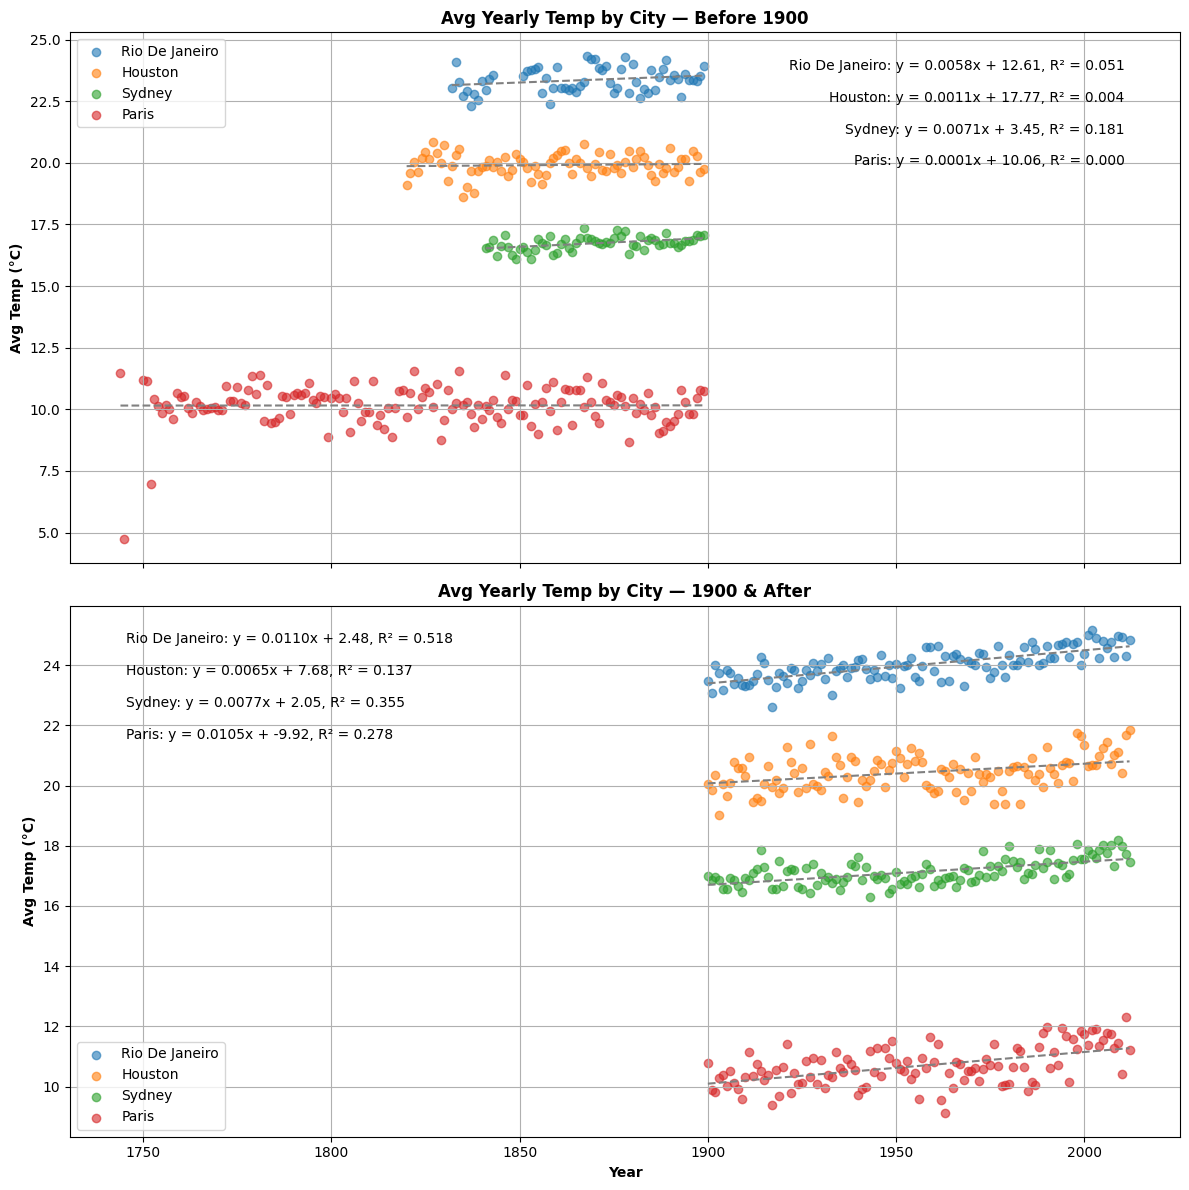

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Load your temperature data
file_path = "C:/Projects/Capstone/CO2-Emissions-and-Global-Temperature-Analysis/Data/Cleaned/Avg_Yearly_Temps.xlsx"
df = pd.read_excel(file_path)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["AvgTemp"] = pd.to_numeric(df["AvgTemp"], errors="coerce")
df = df.dropna(subset=["Year", "AvgTemp"])

# Split into two timeframes
df1 = df[df["Year"] < 1900 ]
df2 = df[df["Year"] >= 1900]

# Define the custom order of cities
cities_order = ["Rio De Janeiro", "Houston", "Sydney", "Paris"]

fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

for ax, (label, subset, xpos, align) in zip(
    axes,
    [
        ("Before 1900", df1, 0.95, "right"),
        ("1900 & After", df2, 0.05, "left")
    ]
):
    y_text = 0.95  # start near the top
    for city in cities_order:
        city_df = subset[subset["City"] == city].sort_values("Year")
        x, y = city_df["Year"], city_df["AvgTemp"]
        if x.empty:
            continue

        ax.scatter(x, y, alpha=0.6, label=city)

        slope, intercept, r, *_ = linregress(x, y)
        ax.plot(x, intercept + slope * x, "--", color="gray")

        eq = f"{city}: y = {slope:.4f}x + {intercept:.2f}, R² = {r**2:.3f}"
        ax.text(
            xpos, y_text, eq,
            transform=ax.transAxes,
            horizontalalignment=align,
            verticalalignment="top",
            fontsize=10
        )
        y_text -= 0.06  # shift each line down

    ax.set_title(f"Avg Yearly Temp by City — {label}", fontweight="bold")
    ax.set_ylabel("Avg Temp (°C)", fontweight="bold")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Year", fontweight="bold")
plt.tight_layout()
plt.show()



In [54]:
import scipy.sparse
import pygam.utils

# Force `.A` use to redirect to `.toarray()`
pygam.utils_old = pygam.utils.cholesky  # backup
def _cholesky_patched(A, sparse, verbose=False):
    import numpy as np
    from scipy import sparse as _sp
    if _sp.issparse(A):
        A = A.toarray()
    return pygam.utils_old(A, sparse=False, verbose=verbose)

pygam.utils.cholesky = _cholesky_patched

# Now import and use GAM
from pygam import LinearGAM, s

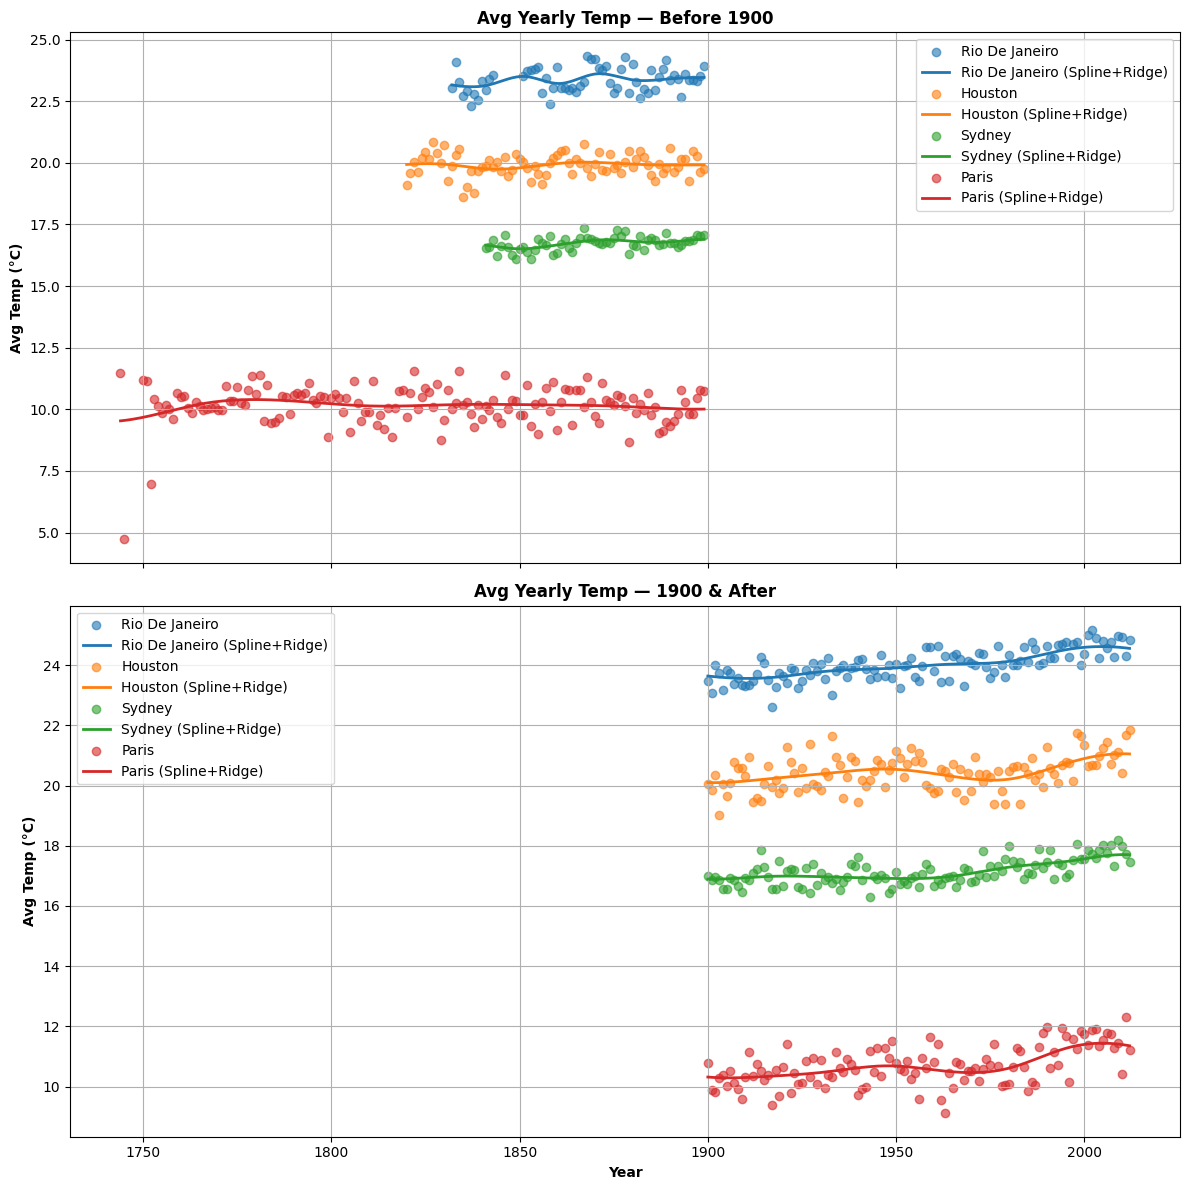

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge

# Load your data
file_path = "C:/Projects/Capstone/CO2-Emissions-and-Global-Temperature-Analysis/Data/Cleaned/Avg_Yearly_Temps.xlsx"
df = pd.read_excel(file_path)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["AvgTemp"] = pd.to_numeric(df["AvgTemp"], errors="coerce")
df = df.dropna(subset=["Year", "AvgTemp"])

# Split periods
df1 = df[df["Year"] < 1900]
df2 = df[df["Year"] >= 1900]

cities_order = ["Rio De Janeiro", "Houston", "Sydney", "Paris"]
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

for ax, (label, subset) in zip(axes, [("Before 1900", df1), ("1900 & After", df2)]):
    for city in cities_order:
        city_df = subset[subset["City"] == city].sort_values("Year")
        if city_df.empty:
            continue

        X = city_df["Year"].values.reshape(-1,1)
        y = city_df["AvgTemp"].values

        # Pipeline: spline basis -> ridge regression
        model = make_pipeline(
            SplineTransformer(degree=3, n_knots=8, extrapolation="linear"),
            Ridge(alpha=1.0)
        )
        model.fit(X, y)

        # Predict on fine grid
        XX = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
        YY = model.predict(XX)

        ax.scatter(X, y, alpha=0.6, label=city)
        ax.plot(XX, YY, '-', linewidth=2, label=f"{city} (Spline+Ridge)")

    ax.set_title(f"Avg Yearly Temp — {label}", fontweight="bold")
    ax.set_ylabel("Avg Temp (°C)", fontweight="bold")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Year", fontweight="bold")
plt.tight_layout()
plt.show()
